In [1]:
import pandas  as pd
from feature_selector import FeatureSelector
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split

data = pd.read_csv('train.csv')

train_labels = data.satisfied
train = data.drop(columns=['satisfied', 'id'])

fs = FeatureSelector(data = train, labels = train_labels)

fs.identify_all(selection_params = {'missing_threshold': 0.5,    
                                    'correlation_threshold': 0.8, 
                                    'task': 'classification',    
                                    'eval_metric': 'auc', 
                                    'cumulative_importance': 0.99})



/Users/weiyuan/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,4,6,10,12,18,24,35,56,57,65,85,86,87,88,89,98,99,100,105,124,125,126,127,128,130,131,133,166,171,172,192,193,194,195,204,205,206,207,228,229,230,240,256,257,258,259,260,261,262) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


9 features with greater than 0.50 missing values.

0 features with a single unique value.

1 features with a correlation magnitude greater than 0.80.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	valid_0's auc: 0.888154	valid_0's binary_logloss: 0.422517
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	valid_0's auc: 0.889534	valid_0's binary_logloss: 0.419474
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[134]	valid_0's auc: 0.892652	valid_0's binary_logloss: 0.41491
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	valid_0's auc: 0.899642	valid_0's binary_logloss: 0.402468
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[282]	valid_0's auc: 0.890874	valid_0's binary_logloss: 0.416167
Traini

In [2]:
train_removed_all_once = fs.remove(methods = 'all', keep_one_hot = False)
train_removed_with_dummy = fs.remove(methods = 'all', keep_one_hot = True)


selected_features = train_removed_all_once.columns
selected_features_with_dummy = train_removed_with_dummy.columns
selected_features_with_dummy = list(set(selected_features_with_dummy))
selected_features_with_dummy.remove('v88_.a')
selected_features_with_dummy.remove('v89_.a')

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 6083 features including one-hot features.
['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 4714 features.


In [266]:
train_new = train[list(train_removed_all_once.columns)]

In [269]:
train_new.to_csv('selected_train_features.csv')

In [264]:
train_removed_with_dummy.head()

,v1_0,v1_1,v1_10,v1_2,v1_3,v1_4,v1_5,v1_6,v1_7,v1_8,...,v260,v263,v264,v265,v266,v267,v268,v269,v270,cntry
0,0,0,0,1,0,0,0,0,0,0,...,NaN,.a,.a,.a,.a,.a,.a,.a,NaN,AT
1,0,0,0,0,0,1,0,0,0,0,...,NaN,.a,.a,.a,.a,.a,.a,.a,NaN,AT
2,0,0,0,0,0,0,0,1,0,0,...,NaN,1963,1993,1995,.a,.a,.a,.a,NaN,AT
3,0,0,1,0,0,0,0,0,0,0,...,NaN,.a,.a,.a,.a,.a,.a,.a,NaN,AT
4,1,0,0,0,0,0,0,0,0,0,...,NaN,.a,.a,.a,.a,.a,.a,.a,NaN,AT


In [3]:
test_data = pd.read_csv('test.csv')
test_data_select = test_data[selected_features]

/Users/weiyuan/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,6,10,12,21,24,35,85,87,88,89,100,124,126,127,128,130,131,133,166,172,177,193,194,195,205,206,207,220,222,228,229,230,240,257,258,260,261,262) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:

before_X = train_removed_all_once.loc[:,~train_removed_all_once.columns.duplicated()]

orginal_columns = before_X.columns
after_X = pd.concat([before_X, pd.get_dummies(before_X)], axis=1, sort=False)


X = after_X[selected_features_with_dummy]
X = X.loc[:,~X.columns.duplicated()]
X = X.drop(columns = train_removed_all_once.columns)
y = train_labels


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=441)

In [28]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# set xgboost params
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.1,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

# training and testing - numpy matrices
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)

# extracting most confident predictions
best_preds = np.asarray([np.argmax(line) for line in preds])


/Users/weiyuan/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [27]:
from sklearn.metrics import precision_score
print ("Numpy array precision:", precision_score(y_test, best_preds, average='macro'))

Numpy array precision: 0.24119015957446807


/Users/weiyuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Light GBM

In [47]:
import lightgbm as lgb
import time
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# specify parameters via map

params = {
    'num_leaves':31,                # Same to max_leaf_nodes in GBDT, but GBDT's default value is None
    'max_depth': -1,                # Same to max_depth of xgboost
    'tree_learner': 'serial', 
    'application':'multiclass',     # Same to objective of xgboost
    'num_class':10,                 # Same to num_class of xgboost
    'learning_rate': 0.1,           # Same to eta of xgboost
    'min_split_gain': 0,            # Same to gamma of xgboost
    'lambda_l1': 0,                 # Same to alpha of xgboost
    'lambda_l2': 0,                 # Same to lambda of xgboost
    'min_data_in_leaf': 20,         # Same to min_samples_leaf of GBDT
    'bagging_fraction': 1.0,        # Same to subsample of xgboost
    'bagging_freq': 0,
    'bagging_seed': 0,
    'feature_fraction': 1.0,         # Same to colsample_bytree of xgboost
    'feature_fraction_seed': 2,
    'min_sum_hessian_in_leaf': 1e-3, # Same to min_child_weight of xgboost
    'num_threads': 1,
}
num_round = 10

# start training
start_time = time.time()
bst = lgb.train(params, train_data, num_round)
end_time = time.time()
print('The training time = {}'.format(end_time - start_time))

# get prediction and evaluate
ypred_onehot = bst.predict(X_test)
ypred = []
for i in range(len(ypred_onehot)):
    ypred.append(ypred_onehot[i].argmax())

accuracy = np.sum(ypred == y_test) / len(ypred)
print('Test accuracy = {}'.format(accuracy))

The training time = 3.6820030212402344
Test accuracy = 0.7310505319148937


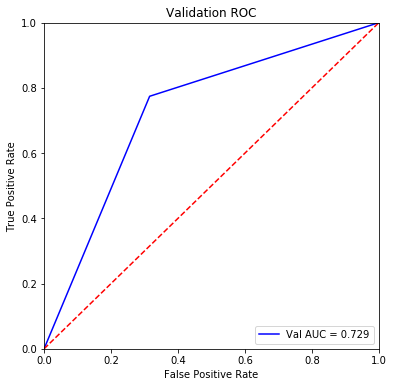

In [50]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, threshold = metrics.roc_curve(y_test, ypred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [236]:
#lightgbm
lgb_train = lgb.Dataset(X_train,y_train)
lgb_test = lgb.Dataset(X_test,y_test,reference=lgb_train)
lgb_origi_params = {
    'boosting_type':'gbdt',
    'max_depth':-1,
    'num_leaves':20,
    'bagging_fraction':1.0,
    'feature_fraction':1.0,
    'learning_rate':0.05,
    'metric': 'auc',
    'application':'binary'
}
start = time.time()
lgb1 = lgb.train(train_set=lgb_train,
                      early_stopping_rounds=10,
                      num_boost_round=1000,
                      params=lgb_origi_params,
                      valid_sets=lgb_test)
end = time.time()
print('lightgbm运行时间为{}秒'.format(round(end-start,0)))

[1]	valid_0's auc: 0.771808
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.777723
[3]	valid_0's auc: 0.778755
[4]	valid_0's auc: 0.782142
[5]	valid_0's auc: 0.782644
[6]	valid_0's auc: 0.785034
[7]	valid_0's auc: 0.785568
[8]	valid_0's auc: 0.785524
[9]	valid_0's auc: 0.786233
[10]	valid_0's auc: 0.787615
[11]	valid_0's auc: 0.790036
[12]	valid_0's auc: 0.790875
[13]	valid_0's auc: 0.79283
[14]	valid_0's auc: 0.794551
[15]	valid_0's auc: 0.794987
[16]	valid_0's auc: 0.795914
[17]	valid_0's auc: 0.796312
[18]	valid_0's auc: 0.797413
[19]	valid_0's auc: 0.798702
[20]	valid_0's auc: 0.799176
[21]	valid_0's auc: 0.799751
[22]	valid_0's auc: 0.801093
[23]	valid_0's auc: 0.802303
[24]	valid_0's auc: 0.802991
[25]	valid_0's auc: 0.803867
[26]	valid_0's auc: 0.805101
[27]	valid_0's auc: 0.805997
[28]	valid_0's auc: 0.806848
[29]	valid_0's auc: 0.807605
[30]	valid_0's auc: 0.808601
[31]	valid_0's auc: 0.809584
[32]	valid_0's auc: 0.810403
[33]	valid_0's auc: 0

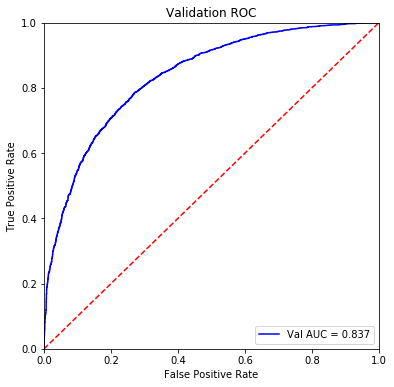

In [238]:
from sklearn import metrics
import matplotlib.pyplot as plt

lgb1_pre=lgb1.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, lgb1_pre)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [248]:
from sklearn.metrics import accuracy_score 
    
def fbeta(y_true, pred):
    # 调整阈值
    best_acc=0
    precision_recall = []
    best_thershold=0
    for thershold in [0.15,0.2, 0.25,0.3,0.4,0.45,0.5,52125, 0.525, 0.55, 0.6, 0.65, 0.7]:
        preds = [1 if i > thershold else 0 for i in pred]
        cur_acc = accuracy_score(y_test, preds)
        if cur_acc > best_acc:
            best_thershold = thershold
            best_acc = cur_acc
            print(best_acc)
    return 'best_thershold', best_thershold,True

In [249]:
lgb1_pre=lgb1.predict(X_test)

fbeta(y_test, lgb1_pre)

0.6341422872340425
0.671376329787234
0.6969747340425532
0.718251329787234
0.745844414893617
0.7538231382978723
0.7561502659574468


('best_thershold', 0.5, True)

In [259]:
submit_pre=lgb1.predict(test)
submit_test_y = [0] * len(test)
for i in range(len(submit_pre)):
    if submit_pre[i] > 0.5:
        submit_test_y[i] = 1
    else:
        submit_test_y[i] = 0
test['Predicted'] = submit_test_y
test_data = pd.read_csv('test.csv')
id_ = test_data['id']
test['Id'] = id_
df = test[['Id', 'Predicted']]
df.to_csv('submission.csv',index=False)


/Users/weiyuan/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,6,10,12,21,24,35,85,87,88,89,100,124,126,127,128,130,131,133,166,172,177,193,194,195,205,206,207,220,222,228,229,230,240,257,258,260,261,262) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 第二次 LGB 尝试

In [254]:
params = {'boosting_type': 'gbdt',
          'num_leaves': 60, #结果对最终效果影响较大，越大值越好，太大会出现过拟合
          'min_data_in_leaf': 30,
          'objective': 'binary', #定义的目标函数
          'max_depth': -1,
          'learning_rate': 0.03,
          "min_sum_hessian_in_leaf": 6,
          "boosting": "gbdt",
          "feature_fraction": 0.9,  #提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "lambda_l1": 0.1,             #l1正则
          # 'lambda_l2': 0.001,     #l2正则
          "verbosity": -1,
          "nthread": -1,                #线程数量，-1表示全部线程，线程越多，运行的速度越快
          'metric': {'binary_logloss', 'auc'},  ##评价函数选择
          "random_state": 2019, #随机数种子，可以防止每次运行的结果不一致
          # 'device': 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
          }

start = time.time()
lgb2 = lgb.train(train_set=lgb_train,
                      early_stopping_rounds=10,
                      num_boost_round=1000,
                      params=params,
                      valid_sets=lgb_test)
end = time.time()
print('lightgbm运行时间为{}秒'.format(round(end-start,0)))

[1]	valid_0's auc: 0.786815	valid_0's binary_logloss: 0.684734
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.794965	valid_0's binary_logloss: 0.677698
[3]	valid_0's auc: 0.799648	valid_0's binary_logloss: 0.670636
[4]	valid_0's auc: 0.801224	valid_0's binary_logloss: 0.664049
[5]	valid_0's auc: 0.801309	valid_0's binary_logloss: 0.658023
[6]	valid_0's auc: 0.802527	valid_0's binary_logloss: 0.652237
[7]	valid_0's auc: 0.802556	valid_0's binary_logloss: 0.646747
[8]	valid_0's auc: 0.802563	valid_0's binary_logloss: 0.641586
[9]	valid_0's auc: 0.802663	valid_0's binary_logloss: 0.63656
[10]	valid_0's auc: 0.802851	valid_0's binary_logloss: 0.63186
[11]	valid_0's auc: 0.802843	valid_0's binary_logloss: 0.627549
[12]	valid_0's auc: 0.803733	valid_0's binary_logloss: 0.62328
[13]	valid_0's auc: 0.805899	valid_0's binary_logloss: 0.618878
[14]	valid_0's auc: 0.807389	valid_0's binary_logloss: 0.615218
[15]	valid_0's auc: 0.808552	valid_0's binary_logloss: 

[129]	valid_0's auc: 0.834494	valid_0's binary_logloss: 0.50291
[130]	valid_0's auc: 0.834634	valid_0's binary_logloss: 0.502662
[131]	valid_0's auc: 0.834809	valid_0's binary_logloss: 0.502399
[132]	valid_0's auc: 0.834836	valid_0's binary_logloss: 0.50228
[133]	valid_0's auc: 0.834956	valid_0's binary_logloss: 0.502072
[134]	valid_0's auc: 0.835095	valid_0's binary_logloss: 0.501836
[135]	valid_0's auc: 0.835245	valid_0's binary_logloss: 0.50161
[136]	valid_0's auc: 0.835423	valid_0's binary_logloss: 0.501425
[137]	valid_0's auc: 0.835516	valid_0's binary_logloss: 0.501256
[138]	valid_0's auc: 0.835616	valid_0's binary_logloss: 0.50107
[139]	valid_0's auc: 0.835654	valid_0's binary_logloss: 0.500984
[140]	valid_0's auc: 0.835634	valid_0's binary_logloss: 0.500945
[141]	valid_0's auc: 0.835711	valid_0's binary_logloss: 0.500811
[142]	valid_0's auc: 0.835771	valid_0's binary_logloss: 0.500677
[143]	valid_0's auc: 0.835869	valid_0's binary_logloss: 0.500529
[144]	valid_0's auc: 0.835959

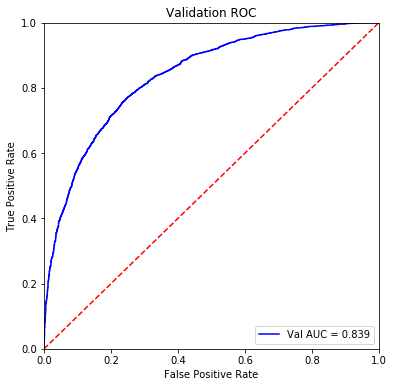

In [255]:
from sklearn import metrics
import matplotlib.pyplot as plt

lgb2_pre=lgb2.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, lgb2_pre)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [256]:
from sklearn.metrics import precision_recall_fscore_support
fbeta(y_test, lgb2_pre)

0.6431183510638298
0.676030585106383
0.7016289893617021
0.7200797872340425
0.7470079787234043
0.7561502659574468
0.7606382978723404


('best_thershold', 0.5, True)

In [262]:
submit_pre=lgb1.predict(test)
submit_test_y = [0] * len(test)
for i in range(len(submit_pre)):
    if submit_pre[i] > 0.5:
        submit_test_y[i] = 1
    else:
        submit_test_y[i] = 0
test['Predicted'] = submit_test_y
test_data = pd.read_csv('test.csv')
id_ = test_data['id']
test['Id'] = id_
df = test[['Id', 'Predicted']]
df.to_csv('submission2.csv',index=False)


/Users/weiyuan/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,6,10,12,21,24,35,85,87,88,89,100,124,126,127,128,130,131,133,166,172,177,193,194,195,205,206,207,220,222,228,229,230,240,257,258,260,261,262) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [261]:
after_test_data_select = pd.concat([test_data_select, pd.get_dummies(test_data_select)], axis=1, sort=False)

# selected_features_with_dummy.remove('v125_21')
# selected_features_with_dummy.remove('v125_15')
after_test_data_select['v125_21'] = 0
after_test_data_select['v125_15'] = 0

test = after_test_data_select[selected_features_with_dummy]
test = test.loc[:,~test.columns.duplicated()]
test = test.drop(columns = train_removed_all_once.columns)

In [8]:
submit_test_y = [0] * len(test)
Dtest_submit = xgb.DMatrix(test, label = submit_test_y)
submit_preds = bst.predict(Dtest_submit)
submit_preds = np.asarray([np.argmax(line) for line in submit_preds])
test['Predicted'] = submit_preds
id_ = test_data['id']
test['Id'] = id_
df = test[['Id', 'Predicted']]
df.to_csv('submission.csv',index=False)
